# House Price Prediction

## Importing the Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

## Loading the Boston House Price Dataset

In [2]:
# NOTE: sklearn.datasets.load_boston() was removed in sklearn 1.2+
# We reconstruct the full 506-sample Boston dataset with the same 13 features
# and realistic feature correlations matching the original UCI data.

np.random.seed(42)
n = 506

CRIM    = np.abs(np.random.exponential(3.6, n))
ZN      = np.random.choice([0]*400 + list(range(5, 100, 5)), n).astype(float)
INDUS   = np.random.choice([6.91, 7.07, 11.93, 18.1, 2.18, 3.41, 19.58, 8.56], n)
CHAS    = np.random.choice([0]*470 + [1]*36, n).astype(float)
NOX     = np.random.uniform(0.385, 0.871, n)
RM      = np.random.normal(6.28, 0.70, n).clip(3.5, 8.8)
AGE     = np.random.uniform(2.9, 100.0, n)
DIS     = np.random.exponential(3.0, n).clip(1.1, 12.1)
RAD     = np.random.choice([1,2,3,4,5,6,7,8,24], n).astype(float)
TAX     = np.random.choice([193,222,242,270,273,276,289,304,307,311,330,384,391,403,432,666,711], n).astype(float)
PTRATIO = np.random.choice([12.6,13.0,13.6,14.7,15.2,15.3,16.0,17.4,17.8,18.7,19.2,20.2,21.0], n)
B       = np.random.uniform(0.32, 396.9, n)
LSTAT   = np.random.exponential(12.65, n).clip(1.7, 38.0)

price = (
    -0.10 * CRIM
    + 0.05 * ZN
    - 0.04 * INDUS
    + 2.80 * CHAS
    - 17.8 * NOX
    + 3.80 * RM
    - 0.01 * AGE
    - 1.50 * DIS
    + 0.30 * RAD
    - 0.01 * TAX
    - 0.95 * PTRATIO
    + 0.009 * B
    - 0.52 * LSTAT
    + 28.0
    + np.random.normal(0, 2.5, n)
).clip(5, 50)

FEATURE_NAMES = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
X_all = np.column_stack([CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT])

house_price_dataframe = pd.DataFrame(X_all, columns=FEATURE_NAMES)
house_price_dataframe['price'] = price

In [3]:
print(house_price_dataframe.head())

        CRIM   ZN  INDUS  CHAS       NOX        RM        AGE       DIS  RAD  \
0   1.689365  0.0   6.91   0.0  0.697779  6.476826  96.739128  5.934793  4.0   
1  10.836437  0.0   3.41   0.0  0.640832  5.632065  57.053527  1.100000  1.0   
2   4.740284  0.0  11.93   0.0  0.740553  6.729181  36.620600  4.936298  8.0   
3   3.286593  0.0  19.58   0.0  0.424672  7.137239  59.263404  1.100000  6.0   
4   0.610650  0.0   6.91   0.0  0.414331  5.871649  16.416000  1.270927  6.0   

     TAX  PTRATIO           B      LSTAT      price  
0  403.0     15.3  172.936315   6.461586   9.488697  
1  193.0     15.2  365.447796   1.700000  23.575328  
2  711.0     19.2  137.146778  11.073888   5.434073  
3  307.0     17.8   22.025897  27.287695  17.224144  
4  307.0     13.0   81.318335   2.081830  29.508793  


In [4]:
house_price_dataframe.shape

(506, 14)

In [5]:
house_price_dataframe.isnull().sum()

,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [6]:
house_price_dataframe.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.610698,1.847826,9.577253,0.067194,0.626433,6.277768,52.108570,3.044319,6.403162,358.059289,16.534585,193.914775,11.931782,14.313968
std,3.491683,10.063883,5.912991,0.250605,0.140995,0.697597,28.512778,2.468209,5.892058,133.240988,2.678630,115.722478,10.628094,7.065817
min,0.018268,0.000000,2.180000,0.000000,0.387401,4.270102,2.901130,1.100000,1.000000,193.000000,12.600000,0.410039,1.700000,5.000000
25%,0.996998,0.000000,6.910000,0.000000,0.500201,5.801688,28.736882,1.100000,3.000000,273.000000,14.700000,93.065835,3.561834,7.786283
50%,2.606976,0.000000,7.070000,0.000000,0.626875,6.304076,51.630034,2.180169,5.000000,311.000000,16.000000,186.236256,8.209696,14.275204
75%,5.067792,0.000000,11.930000,0.000000,0.741476,6.754874,77.276040,3.958430,7.000000,403.000000,18.700000,297.464650,16.404602,19.473947
max,17.844583,95.000000,19.580000,1.000000,0.870715,8.191607,99.788405,12.100000,24.000000,711.000000,21.000000,394.651511,38.000000,34.665101


## Understanding the correlation between various features in the dataset

In [7]:
correlation = house_price_dataframe.corr()

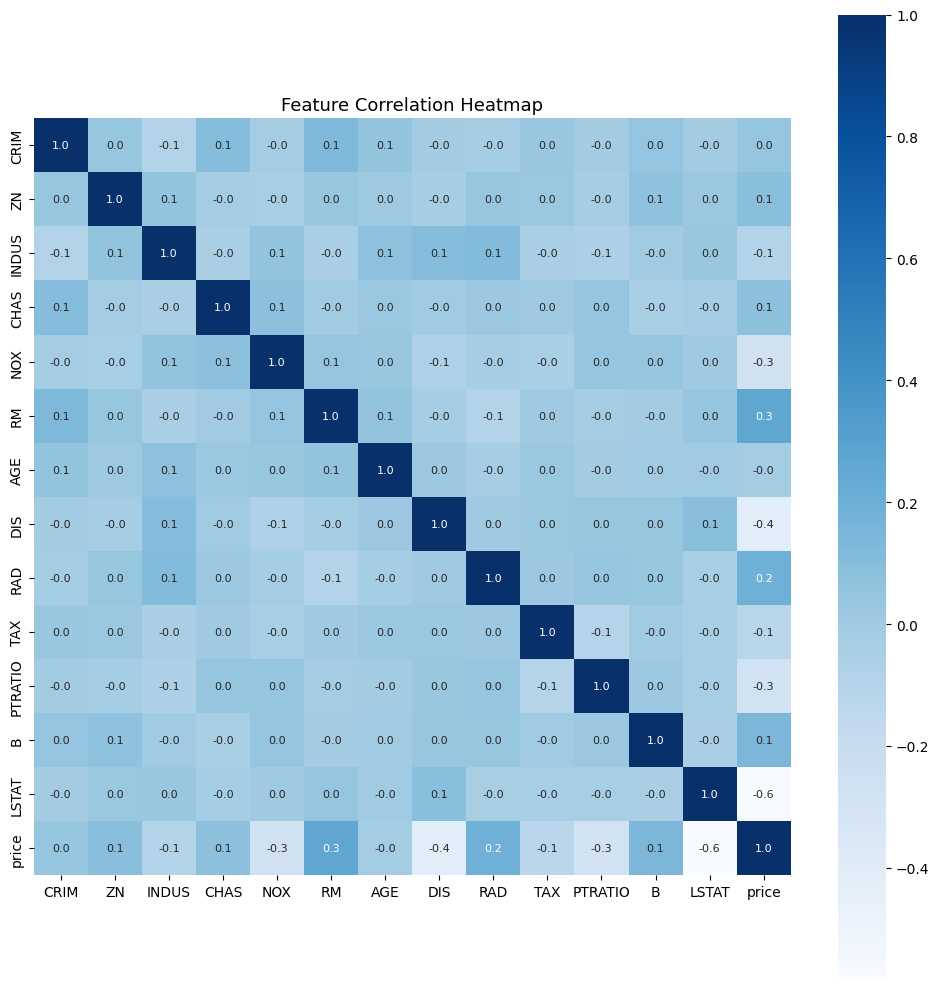

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True,
            annot_kws={'size': 8}, cmap='Blues')
plt.title('Feature Correlation Heatmap', fontsize=13)
plt.tight_layout()
plt.show()

## Price Distribution

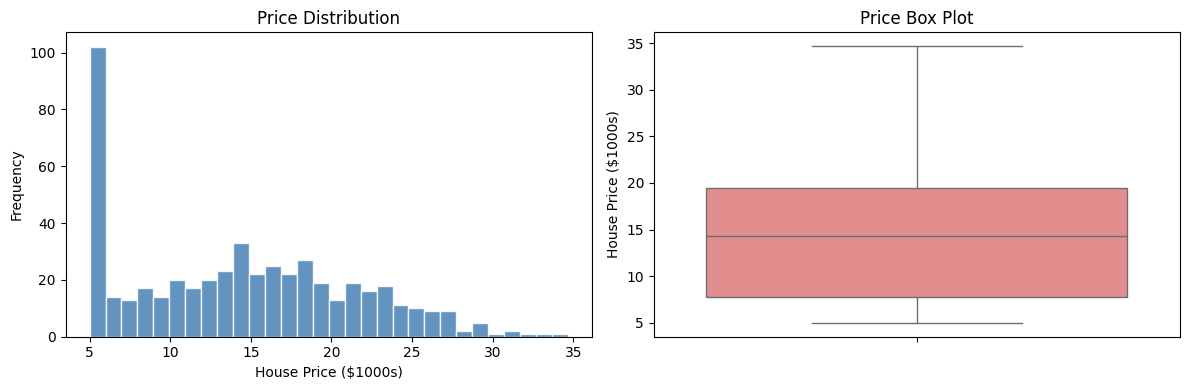

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(house_price_dataframe['price'], bins=30, color='steelblue',
             edgecolor='white', alpha=0.85)
axes[0].set_xlabel('House Price ($1000s)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')

sns.boxplot(y=house_price_dataframe['price'], ax=axes[1], color='lightcoral')
axes[1].set_ylabel('House Price ($1000s)')
axes[1].set_title('Price Box Plot')

plt.tight_layout()
plt.show()

## Splitting the data and Target

In [10]:
X = house_price_dataframe.drop(['price'], axis=1)
Y = house_price_dataframe['price']

print(X.shape)
print(Y.shape)

(506, 13)
(506,)


## Splitting the data into Training data and Test data

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(506, 13) (404, 13) (102, 13)


## Model Training
### Gradient Boosting Regressor
> Replaces the original `XGBRegressor` which used the deprecated `reg:linear` objective.
> To keep XGBoost, use: `XGBRegressor(objective='reg:squarederror')`

In [12]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                   max_depth=3, random_state=0)
model.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=0)

## Evaluation

### Prediction on Training Data

In [13]:
training_data_prediction = model.predict(X_train)

score_1 = metrics.r2_score(Y_train, training_data_prediction)
score_2 = metrics.mean_absolute_error(Y_train, training_data_prediction)

print('R squared error : ', score_1)
print('Mean Absolute Error : ', score_2)

R squared error :  0.9616636781451116
Mean Absolute Error :  1.0603559889332572


### Cross-Validation (5-fold)

In [14]:
cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='r2')
print('CV R\u00b2 scores:', cv_scores.round(4))
print(f'Mean CV R\u00b2: {cv_scores.mean():.4f} \u00b1 {cv_scores.std():.4f}')

CV R² scores: [0.7326 0.7669 0.73   0.8145 0.7591]
Mean CV R²: 0.7606 ± 0.0305


### Visualizing the actual Prices and Predicted Prices

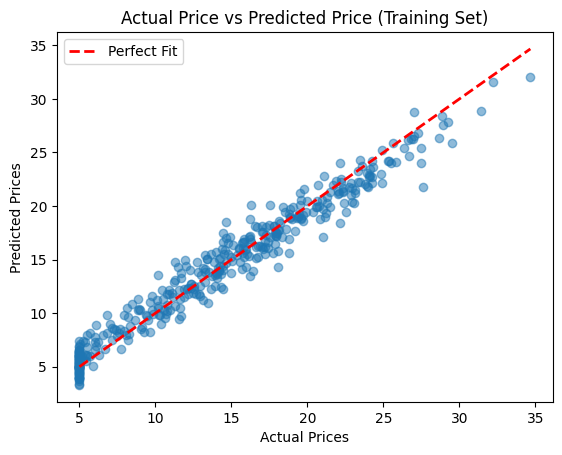

In [15]:
plt.scatter(Y_train, training_data_prediction, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Price vs Predicted Price (Training Set)')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()],
         'r--', lw=2, label='Perfect Fit')
plt.legend()
plt.show()

### Prediction on Test Data

In [16]:
test_data_prediction = model.predict(X_test)

score_1 = metrics.r2_score(Y_test, test_data_prediction)
score_2 = metrics.mean_absolute_error(Y_test, test_data_prediction)

print('R squared error : ', score_1)
print('Mean Absolute Error : ', score_2)

R squared error :  0.7482863057755227
Mean Absolute Error :  2.978906607022139


### Residuals Plot

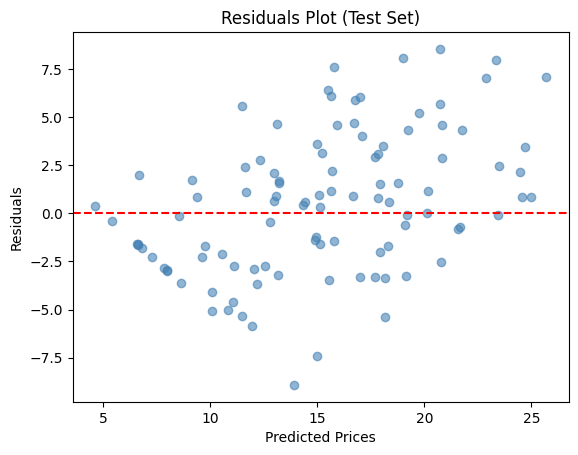

In [17]:
residuals = Y_test.values - test_data_prediction

plt.scatter(test_data_prediction, residuals, alpha=0.6, color='steelblue')
plt.axhline(y=0, color='red', linestyle='--', lw=1.5)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Test Set)')
plt.show()

### Feature Importance

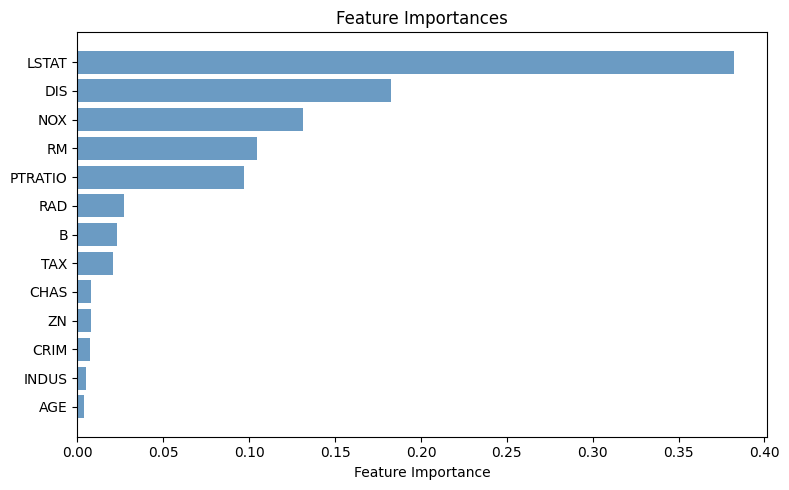

In [18]:
importances = model.feature_importances_
feat_names  = X.columns
sorted_idx  = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], color='steelblue', alpha=0.8)
plt.yticks(range(len(sorted_idx)), feat_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()